In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('timm version', timm.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)


System Version: 3.12.1 (main, Oct 16 2024, 18:21:33) [GCC 9.4.0]
PyTorch version 2.3.0+cu121
Torchvision version 0.18.0+cu121
timm version 1.0.12
Numpy version 2.1.2
Pandas version 2.2.2


In [7]:
class SkinDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(SkinDiseaseClassifier, self).__init__()
        # Load base model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        enet_out_size = self.base_model.num_features

        # Define a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self , x):
        # Extract features from the base model
        x = self.base_model(x)
        # Pass through the classifier
        output = self.classifier(x)
        return output

In [8]:
class SkinDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    @property
    def classes(self):
        return self.data.classes

In [9]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])
data_dir = '/workspaces/codespaces-jupyter/data/dermnet-v1/train'
dataset = SkinDataset(data_dir, train_transform)

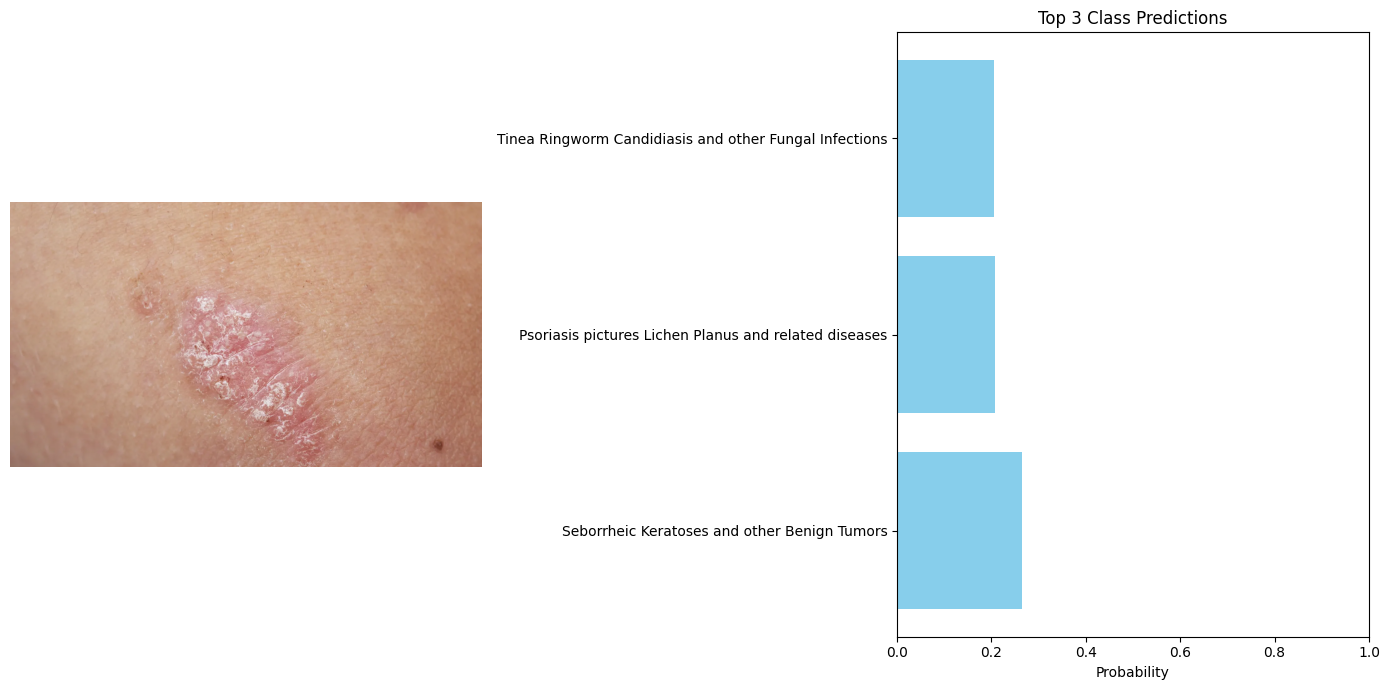

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SkinDiseaseClassifier()
model.load_state_dict(torch.load("/workspaces/codespaces-jupyter/saved-model/dermnet3.pth"))

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    # Get top 3 predictions
    top3_indices = np.argsort(probabilities)[-3:][::-1]  # Indices of top 3 probabilities
    top3_probs = probabilities[top3_indices]
    top3_classes = [class_names[i] for i in top3_indices]

    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(top3_classes, top3_probs, color='skyblue')
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Top 3 Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/workspaces/codespaces-jupyter/data/image.png"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)
